<a href="https://colab.research.google.com/github/BoHye0202/Toy-Project/blob/main/7.%EC%83%9D%EC%B2%B4%20%EA%B4%91%ED%95%99%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/%EC%83%9D%EC%B2%B4%EA%B3%BC%ED%95%99_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-output Regression 문제
4개의 output이 나와야 한다.



In [1]:
import pandas as pd                         # 데이터 분석 패키지
import numpy as np                          # 계산 패키지
import matplotlib.pyplot as plt             # 데이터 시각화 패키지
import seaborn as sns                       # 데이터 시각화 패키지

import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
!nvidia-smi

Sat Jun 19 13:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 데이터 불러오기
- id : 구분자
- rho : 측정 거리 (단위: mm)
- src : 광원 스펙트럼 (650 nm ~ 990 nm)
- dst : 측정 스펙트럼 (650 nm ~ 990 nm)
- hhb : 디옥시헤모글로빈 농도
- hbo2 : 옥시헤모글로빈 농도
- ca : 칼슘 농도
- na : 나트륨 농도

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

print('train shape: ', train.shape)
train.head()

train shape:  (10000, 76)


,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

# 데이터 전처리
### 주요 문제점
1. src와 dst간 단위가 다르다
2. dst에는 다수의 null값이 존재한다
3. target값들은 서로 상관관계가 있고, hhb를 예측할 때 다른 target값을 사용하면 점수가 좋다
4. rho에 따라 dst의 값이 다르다
5. src는 몇가지 패턴이 존재한다
6. hhb, na에는 0이 존재한다.

In [4]:
train.describe()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8.052000e+03,8.012000e+03,8.069000e+03,8.025000e+03,7.997000e+03,8.034000e+03,8.054000e+03,7.954000e+03,7.994000e+03,8.007000e+03,7.929000e+03,7.950000e+03,8.006000e+03,8.055000e+03,7.941000e+03,7.974000e+03,8.010000e+03,7.909000e+03,8.035000e+03,7.955000e+03,7.986000e+03,7.990000e+03,7.980000e+03,8.032000e+03,7.941000e+03,8.001000e+03,7.970000e+03,7.962000e+03,8.022000e+03,7.982000e+03,7.987000e+03,7.992000e+03,7.931000e+03,8.081000e+03,8.013000e+03,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,17.568000,0.180212,0.203529,0.229804,0.259158,0.289975,0.322244,0.354101,0.384492,0.412503,0.436837,0.457967,0.476572,0.492156,0.505204,0.514847,0.521998,0.526279,0.527803,0.526581,0.522834,0.516752,0.508073,0.497672,0.484489,0.468856,0.450071,0.427684,0.402133,0.373510,0.342931,0.311117,0.279036,0.248194,0.220063,0.194771,1.124878e-11,1.049022e-11,7.149459e-12,5.730763e-12,5.830921e-12,9.800478e-12,1.341997e-11,1.478769e-11,1.872129e-11,1.940671e-11,3.368432e-11,4.103896e-11,6.556870e-11,1.535845e-10,2.534842e-10,3.507968e-10,3.742625e-10,3.442563e-10,2.849591e-10,2.357635e-10,2.230534e-10,2.315210e-10,1.960385e-10,1.280135e-10,7.736184e-11,7.976805e-11,6.761949e-11,6.687656e-11,8.491835e-11,7.511190e-11,4.270426e-11,2.498465e-11,4.047717e-11,1.153774e-10,2.364072e-10,7.990686,4.009146,9.019226,3.042651
std,2886.89568,5.595847,0.272859,0.288661,0.306340,0.324849,0.342362,0.357700,0.370451,0.379054,0.382319,0.381070,0.376649,0.370811,0.364924,0.359392,0.354133,0.350876,0.348416,0.346901,0.346015,0.347224,0.349507,0.353201,0.358563,0.365313,0.372194,0.377802,0.381172,0.381287,0.376981,0.369067,0.356267,0.338620,0.319405,0.299366,0.281410,3.950723e-10,3.552589e-10,1.810768e-10,1.033245e-10,5.532230e-11,1.437367e-10,1.753800e-10,1.267547e-10,1.908160e-10,1.594302e-10,2.911465e-10,3.835104e-10,5.001364e-10,1.053443e-09,1.502732e-09,1.881377e-09,1.948361e-09,1.735492e-09,1.504526e-09,1.310408e-09,1.241880e-09,1.236564e-09,8.995359e-10,6.467676e-10,3.857980e-10,3.778529e-10,3.336177e-10,3.453981e-10,4.335765e-10,3.831916e-10,2.293432e-10,1.639150e-10,2.134495e-10,5.179299e-10,1.058272e-09,2.970818,0.997828,2.979453,1.881872
min,0.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

### missing value

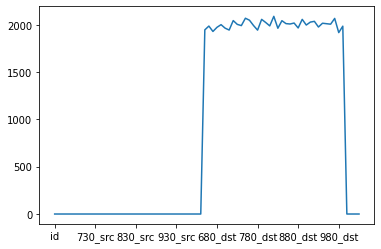

In [6]:
train.isna().sum().plot()

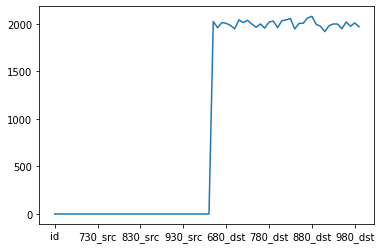

In [7]:
test.isna().sum().plot()

###  outlier

### Feature Engineering

In [10]:
src_col = ['650_src', '660_src', '670_src', '680_src', '690_src',
       '700_src', '710_src', '720_src', '730_src', '740_src', '750_src',
       '760_src', '770_src', '780_src', '790_src', '800_src', '810_src',
       '820_src', '830_src', '840_src', '850_src', '860_src', '870_src',
       '880_src', '890_src', '900_src', '910_src', '920_src', '930_src',
       '940_src', '950_src', '960_src', '970_src', '980_src', '990_src']
dst_col = ['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
tgt_col = ['hhb', 'hbo2', 'ca', 'na']

In [11]:
def simple_fe(train):
    """
    전체 파장에 대한 src, dst 평균 / mean 투과도 / std 투과도
    """
    train['src_mean']=train[src_col].mean(1)
    train['dst_mean']=train[dst_col].mean(1)
    train['Trans_mean'] = train['dst_mean']/train['src_mean']

    train['src_std']=train[src_col].std(1)
    train['dst_std']=train[dst_col].std(1)
    train['Trans_std'] = train['dst_std']/train['src_std']

    return train

train = simple_fe(train)
test = simple_fe(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na,src_mean,dst_mean,Trans_mean,src_std,dst_std,Trans_std
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29,0.451666,1.683739e-17,3.727841e-17,0.317979,2.680274e-17,8.429081e-17
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64,0.231403,2.111984e-09,9.126869e-09,0.358946,3.816205e-09,1.063169e-08
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16,0.415092,1.637732e-18,3.945464e-18,0.354671,2.988555e-18,8.426279e-18
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35,0.448663,6.775444e-10,1.510141e-09,0.306165,8.361614e-10,2.731083e-09
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,...,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2

### binning
binning작업은 feature값의 특성과 feature의 분포를 고려하여 몇 가지 feature 들 중 연속적인 특성을 가진 feature들에 대하여 그룹 특성으로 변환시키는 작업을 의미합니다.

In [12]:
def binning_fe(train, src_col, dst_col, size=50):
    """
    size 별로 binning후 피쳐 생성
    """
    for i in range(650, 1000-size, size):
        temp1=train.loc[:, '%s_src'%i : '%s_src'%(i+size)].mean(1)
        temp2=train.loc[:, '%s_dst'%i : '%s_dst'%(i+size)].mean(1)
        train['Trans_%s_to_%s_mean'%(i,i+size)] = temp2/temp1
        train['Concen_%s_to_%s_mean'%(i,i+size)] = np.log(temp2/temp1) / train['rho']
    
    return train

for i in [10, 20,30,40, 50,100]:
    train = binning_fe(train, src_col, dst_col, size=i)
    test = binning_fe(test, src_col, dst_col, size=i)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,Trans_890_to_920_mean,Concen_890_to_920_mean,Trans_920_to_950_mean,Concen_920_to_950_mean,Trans_950_to_980_mean,Concen_950_to_980_mean,Trans_650_to_690_mean,Concen_650_to_690_mean,Trans_690_to_730_mean,Concen_690_to_730_mean,Trans_730_to_770_mean,Concen_730_to_770_mean,Trans_770_to_810_mean,Concen_770_to_810_mean,Trans_810_to_850_mean,Concen_810_to_850_mean,Trans_850_to_890_mean,Concen_850_to_890_mean,Trans_890_to_930_mean,Concen_890_to_930_mean,Trans_930_to_970_mean,Concen_930_to_970_mean,Trans_650_to_700_mean,Concen_650_to_700_mean,Trans_700_to_750_mean,Concen_700_to_750_mean,Trans_750_to_800_mean,Concen_750_to_800_mean,Trans_800_to_850_mean,Concen_800_to_850_mean,Trans_850_to_900_mean,Concen_850_to_900_mean,Trans_900_to_950_mean,Concen_900_to_950_mean,Trans_650_to_750_mean,Concen_650_to_750_mean,Trans_750_to_850_mean,Concen_750_to_850_mean,Trans_850_to_950_mean,Concen_850_to_950_mean
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,2.051025e-17,-1.537024,2.865128e-18,-1.615757,2.615970e-17,-1.527292,8.426583e-18,-1.572606,4.748659e-18,-1.595547,2.475236e-18,-1.621608,7.993064e-17,-1.482615,9.875685e-17,-1.474155,4.033992e-17,-1.509968,1.600755e-17,-1.546939,5.597140e-18,-1.588971,6.786499e-18,-1.581264,1.851082e-18,-1.633230,5.236442e-17,-1.499532,1.226882e-16,-1.465475,4.327316e-17,-1.507160,1.147891e-17,-1.560241,4.313845e-18,-1.599388,6.563295e-17,-1.490498,3.515513e-17,-1.515470
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,5.753152e-09,-1.897352,9.882205e-09,-1.843253,7.412564e-09,-1.872009,1.666183e-08,-1.791015,5.584201e-09,-1.900332,3.594243e-08,-1.714135,7.850195e-08,-1.636014,2.436322e-07,-1.522761,1.454212e-08,-1.804622,8.811522e-09,-1.854721,9.390495e-09,-1.848357,7.976736e-09,-1.864674,3.847423e-09,-1.937586,5.751336e-08,-1.667125,1.346864e-07,-1.582032,1.062700e-08,-1.835987,9.937559e-09,-1.842694,8.493414e-09,-1.858397,8.362563e-08,-1.629692,1.041157e-08,-1.838035
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,7.679790e-18,-1.576318,4.306935e-18,-1.599452,5.398802e-18,-1.590414,2.258217e-18,-1.625278,4.293359e-18,-1.599578,8.436045e-19,-1.664664,4.075121e-18,-1.601665,1.084443e-17,-1.562515,1.705646e-18,-1.636504,6.910306e-18,-1.580541,0.000000e+00,-inf,1.699254e-18,-1.636654,2.145231e-18,-1.627331,1.166380e-18,-1.651705,7.348514e-18,-1.578081,2.960700e-18,-1.614444,5.779307e-18,-1.587690,2.399003e-18,-1.622859,5.079388e-18,-1.592854,2.942280e-18,-1.614694
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,5.482488e-10,-2.132429,1.300212e-09,-2.046074,2.065064e-09,-1.999810,8.492614e-11,-2.318924,8.440804e-11,-2

### rolling

In [13]:
def rolling_fe(train):
    """
    window size별 롤링후 피쳐 생성
    """
    temp = [x for x in range(650,1000,10)]
    for k in [3, 5]:# window size
        temp1 = train[src_col].rolling(window = k, min_periods=1, axis=1).mean()
        temp2 = train[dst_col].rolling(window = k, min_periods=1, axis=1).mean()
        for i in temp:
            train['%s_rolling_size_%s'%(i, k)] = np.log(temp2['%s_dst'%i]/temp1['%s_src'%i])/train['rho']
        
    return train

train = rolling_fe(train)
test = rolling_fe(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,950_rolling_size_3,960_rolling_size_3,970_rolling_size_3,980_rolling_size_3,990_rolling_size_3,650_rolling_size_5,660_rolling_size_5,670_rolling_size_5,680_rolling_size_5,690_rolling_size_5,700_rolling_size_5,710_rolling_size_5,720_rolling_size_5,730_rolling_size_5,740_rolling_size_5,750_rolling_size_5,760_rolling_size_5,770_rolling_size_5,780_rolling_size_5,790_rolling_size_5,800_rolling_size_5,810_rolling_size_5,820_rolling_size_5,830_rolling_size_5,840_rolling_size_5,850_rolling_size_5,860_rolling_size_5,870_rolling_size_5,880_rolling_size_5,890_rolling_size_5,900_rolling_size_5,910_rolling_size_5,920_rolling_size_5,930_rolling_size_5,940_rolling_size_5,950_rolling_size_5,960_rolling_size_5,970_rolling_size_5,980_rolling_size_5,990_rolling_size_5
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,-1.614340,-inf,-1.588452,-1.509800,-1.437775,-1.583298,-1.590668,-1.610538,-1.588559,-1.572606,-1.581010,-1.581175,-1.585836,-1.595547,-1.702270,-1.628739,-1.629638,-1.621608,-1.619690,-1.529474,-1.487407,-1.482615,-1.462802,-1.462499,-1.461800,-1.474155,-1.473336,-1.480996,-1.497292,-1.509968,-1.518748,-1.561738,-1.556810,-1.546939,-1.545491,-1.558641,-1.615543,-1.588971,-1.529856,-1.456651
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.833159,-1.869091,-1.916208,-1.866069,-1.800612,NaN,NaN,-inf,-1.832475,-1.791015,-1.864674,-1.872810,-1.814590,-1.900332,-inf,-1.853684,-1.754914,-1.714135,-1.736449,-1.667301,-1.672285,-1.636014,-1.636139,-1.607371,-1.600264,-1.522761,1.864570,-1.658030,-1.747282,-1.804622,-1.854219,-1.893464,-1.893989,-1.854721,-1.832753,-1.836491,-1.858407,-1.848357,-1.849539,-1.865077
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,-3.003674,-2.991595,-2.970635,-1.564894,-1.535687,inf,-1.584593,-1.590405,-1.614728,-1.625278,-1.695604,-1.584448,-1.607720,-1.599578,-1.618232,-1.631912,-1.650935,-1.664664,-1.638378,-1.637054,-1.647974,-1.601665,-1.580461,-1.576462,-1.578110,-1.562515,-1.587304,-1.737589,-1.762593,-1.636504,-1.611928,-1.599963,-1.589736,-1.580541,-1.584685,-1.601753,-1.602889,-inf,-1.611025,-1.586282
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,-2.040160,-2.049173,-2.066127,-1.982351,-1.917614,-2.264009,-2.270651,-2.259645,-2.299160,-2.318924,-2.335681,-2.372316,-2.425890,-2.319536,-2.313202,-2.272791,-2.219126,-2.199104,-2.127452,-2.077734,-2.028864,-1.993656,-1.967126,-1.953430,-1.949138,-1.952271,-1.958615,-1.967701,-1.976813,-1.977242,-2.002892,-2.042623,-2.073681,-2.105213,-2.077506,-2.066372,-2.055650,-2.044969,-2.005795,-1.992291
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.0000

In [14]:
def rolling_fe2(train):
    """
    3, 5 각 윈도우 사이즈로 만든 피쳐끼리 나누기
    """
    temp = [x for x in range(650,1000,10)]
    for i in temp:
        train['%s_rolling_size_3/5'%i] = train['%s_rolling_size_3'%i]/ train['%s_rolling_size_5'%i]
        
    return train

train = rolling_fe2(train)
test = rolling_fe2(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,950_rolling_size_5,960_rolling_size_5,970_rolling_size_5,980_rolling_size_5,990_rolling_size_5,650_rolling_size_3/5,660_rolling_size_3/5,670_rolling_size_3/5,680_rolling_size_3/5,690_rolling_size_3/5,700_rolling_size_3/5,710_rolling_size_3/5,720_rolling_size_3/5,730_rolling_size_3/5,740_rolling_size_3/5,750_rolling_size_3/5,760_rolling_size_3/5,770_rolling_size_3/5,780_rolling_size_3/5,790_rolling_size_3/5,800_rolling_size_3/5,810_rolling_size_3/5,820_rolling_size_3/5,830_rolling_size_3/5,840_rolling_size_3/5,850_rolling_size_3/5,860_rolling_size_3/5,870_rolling_size_3/5,880_rolling_size_3/5,890_rolling_size_3/5,900_rolling_size_3/5,910_rolling_size_3/5,920_rolling_size_3/5,930_rolling_size_3/5,940_rolling_size_3/5,950_rolling_size_3/5,960_rolling_size_3/5,970_rolling_size_3/5,980_rolling_size_3/5,990_rolling_size_3/5
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,-1.558641,-1.615543,-1.588971,-1.529856,-1.456651,1.0,1.0,1.0,1.000898,0.996091,0.992673,0.996367,1.061490,inf,inf,0.991119,0.990410,0.989367,1.015329,0.989190,0.985880,0.985857,0.992298,1.000795,1.003395,1.005149,1.011466,1.005146,1.010351,1.050259,1.040410,0.985592,0.980805,0.998132,1.028586,1.035735,inf,0.999674,0.986890,0.987041
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.836491,-1.858407,-1.848357,-1.849539,-1.865077,NaN,NaN,NaN,1.000000,1.000000,0.965060,1.026611,inf,inf,NaN,0.978218,1.012715,0.977844,0.973961,0.976629,0.993657,0.999378,0.989375,0.951399,-inf,-inf,inf,1.009157,1.014186,1.014191,1.011093,1.014086,0.997473,0.988406,0.999285,0.998186,1.005749,1.036709,1.008938,0.965436
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,-1.601753,-1.602889,-inf,-1.611025,-1.586282,NaN,1.0,1.0,1.039118,1.916432,1.847376,0.990748,0.997629,1.007166,1.012222,1.006998,1.013106,1.021608,0.992059,0.996634,0.993423,0.991546,0.997918,0.991147,0.989225,NaN,1.095261,0.998922,0.998056,0.987703,0.988908,0.987843,0.989930,1.006244,1.005081,1.875241,1.866377,0.000000,0.971365,0.968104
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,-2.066372,-2.055650,-2.044969,-2.005795,-1.992291,1.0,1.0,1.0,1.006468,1.009893,1.019402,1.015997,1.000094,0.988730,0.966760,0.986397,0.999011,0.996766,0.991026,0.979569,0.976672,0.979703,0.988213,0.997463,1.003290,1.004909,1.002496,1.003458,1.008778,1.013990,1.026398,1.045416,1.025492,0.996636,0.982897,0.987315,0.996849,1.010346,0.988312,0.962517
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.9886

In [15]:
def rolling_fe3(train, near):
    """
    서로 가까운 영역의 롤링 피쳐들끼리 나눠주기
    """
    temp = [x for x in range(650,1000-near, 10)]
    for i in temp:
        train['near_%s_%s_size_3'%(i,i+near)] = train['%s_rolling_size_%s'%(i, 3)] / train['%s_rolling_size_%s'%(i+near, 3)]
        train['near_%s_%s_size_5'%(i,i+near)] = train['%s_rolling_size_%s'%(i, 5)] / train['%s_rolling_size_%s'%(i+near, 5)]
    return train

for i in range(10, 30, 10):
    train = rolling_fe3(train,i)
    test = rolling_fe3(test, i)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,near_780_800_size_3,near_780_800_size_5,near_790_810_size_3,near_790_810_size_5,near_800_820_size_3,near_800_820_size_5,near_810_830_size_3,near_810_830_size_5,near_820_840_size_3,near_820_840_size_5,near_830_850_size_3,near_830_850_size_5,near_840_860_size_3,near_840_860_size_5,near_850_870_size_3,near_850_870_size_5,near_860_880_size_3,near_860_880_size_5,near_870_890_size_3,near_870_890_size_5,near_880_900_size_3,near_880_900_size_5,near_890_910_size_3,near_890_910_size_5,near_900_920_size_3,near_900_920_size_5,near_910_930_size_3,near_910_930_size_5,near_920_940_size_3,near_920_940_size_5,near_930_950_size_3,near_930_950_size_5,near_940_960_size_3,near_940_960_size_5,near_950_970_size_3,near_950_970_size_5,near_960_980_size_3,near_960_980_size_5,near_970_990_size_3,near_970_990_size_5
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,1.121463,1.088935,1.035094,1.031606,1.010244,1.016821,0.998623,1.013754,0.989619,1.000686,0.987796,0.992093,0.984252,0.992170,0.995383,0.995381,0.985086,0.984000,0.938683,0.980813,0.957389,0.985873,1.030288,0.966851,1.034836,0.975551,0.996883,1.009566,0.960531,1.007324,0.956459,0.992492,0.000000,0.956639,1.016297,0.980912,inf,1.056010,1.104799,1.090838
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,1.017787,1.038369,0.995926,1.019124,1.026516,1.022093,1.069148,1.017820,-0.000000,1.022418,-0.000000,1.055564,NaN,-0.858248,-inf,0.918416,-inf,-1.067126,0.914208,0.918769,0.945210,0.942328,0.953177,0.953079,0.992370,0.979002,1.047413,1.020889,1.031538,1.033412,1.000032,1.009926,0.979857,0.986196,0.956660,0.993580,1.001619,1.004795,1.064198,0.991035
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,0.992812,0.994177,1.027341,1.022095,1.038020,1.042717,1.016396,1.015987,1.010291,1.001490,NaN,1.008926,0.897955,0.994208,NaN,0.899243,0.988259,0.900550,1.073829,1.061769,1.103583,1.093469,1.022693,1.022838,1.012912,1.013959,0.993778,1.012288,0.988065,1.003188,0.529488,0.986757,0.532404,0.988643,1.011122,0.000000,1.911692,0.994950,1.934402,inf
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,1.064004,1.048593,1.042030,1.042173,1.019339,1.031384,1.002420,1.020592,0.994063,1.009229,0.993180,1.000594,0.995949,0.995162,0.993593,0.992159,0.984624,0.990794,0.984838,0.995175,0.970036,0.986979,0.938893,0.967992,0.966716,0.965863,1.017758,0.970269,1.041415,0.998159,1.028416,1.018797,0.996487,1.010632,0.987432,1.010466,1.033708,1.024855,1.077446,1.026441
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98

In [17]:
def core_fe(train):
    """
    파장대별로 투과도 피쳐와, 농도와 직결되는 피쳐 생성
    """
    temp = [x for x in range(650,1000,10)]
    for i in temp:
        train['Trans_%s'%i] = train['%s_dst'%i]/train['%s_src'%i]
        train['Concen_%s'%i] = np.log(train['%s_dst'%i]/train['%s_src'%i])/train['rho']
    return train

train = core_fe(train)
test = core_fe(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,Trans_800,Concen_800,Trans_810,Concen_810,Trans_820,Concen_820,Trans_830,Concen_830,Trans_840,Concen_840,Trans_850,Concen_850,Trans_860,Concen_860,Trans_870,Concen_870,Trans_880,Concen_880,Trans_890,Concen_890,Trans_900,Concen_900,Trans_910,Concen_910,Trans_920,Concen_920,Trans_930,Concen_930,Trans_940,Concen_940,Trans_950,Concen_950,Trans_960,Concen_960,Trans_970,Concen_970,Trans_980,Concen_980,Trans_990,Concen_990
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,1.813783e-16,-1.449838,NaN,NaN,1.663314e-16,-1.453302,1.101781e-16,-1.469777,6.862712e-17,-1.488714,6.225956e-17,-1.492609,6.701691e-17,-1.489663,NaN,NaN,0.000000e+00,-inf,1.318382e-17,-1.554702,NaN,NaN,2.682411e-17,-1.526289,NaN,NaN,5.985132e-18,-1.586290,NaN,NaN,0.000000e+00,-inf,NaN,NaN,1.437910e-17,-1.551230,7.713706e-17,-1.484038,7.909164e-16,-1.390934
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,5.776891e-08,-1.666682,NaN,NaN,inf,inf,NaN,NaN,inf,inf,NaN,NaN,inf,inf,3.296646e-08,-1.722778,1.350776e-08,-1.812000,5.660728e-09,-1.898971,6.386610e-09,-1.886906,NaN,NaN,6.213321e-09,-1.889657,1.296920e-08,-1.816069,1.345783e-08,-1.812370,6.292266e-09,-1.888394,2.447638e-09,-1.982814,NaN,NaN,1.531222e-08,-1.799461,NaN,NaN
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,0.000000e+00,-inf,1.068405e-17,-1.563111,1.118361e-17,-1.561283,NaN,NaN,NaN,NaN,NaN,NaN,1.402556e-19,-1.736433,NaN,NaN,0.000000e+00,-inf,6.678083e-18,-1.581908,1.001498e-17,-1.565698,3.603440e-18,-1.606586,1.161261e-17,-1.559778,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,3.386971e-17,-1.516960,NaN,NaN
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,3.572361e-09,-1.945004,3.745592e-09,-1.940269,3.502945e-09,-1.946966,2.995182e-09,-1.962626,3.082153e-09,-1.959764,2.974328e-09,-1.963325,2.804527e-09,-1.969203,2.093987e-09,-1.998420,1.498846e-09,-2.031857,NaN,NaN,7.131775e-10,-2.106129,4.041843e-10,-2.162915,NaN,NaN,1.242449e-09,-2.050618,1.576471e-09,-2.026808,1.283341e-09,-2.047380,7.839067e-10,-2.096673,NaN,NaN,3.885699e-09,-1.936596,NaN,NaN
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,...,NaN,NaN,4.432624e-13,-1.896308,2.852355e-13,-1.925697,4.549098e-13,-1.894578,1.341316e-13,-1.975997,1.897625e-13,-1.952867,1.413253e-13,-1.972514,1.740599e-13,-1.958625,1.570932e-13,-1.965462,NaN,NaN,0.0000

In [18]:
def core_fe2(train):
    """
    모든 파장대의 피쳐끼리 서로 빼기 나누기
    """
    temp = [x for x in range(650,1000,10)]
    temp_col = []
    for i in temp:
        temp_col.append('Concen_%s'%i)

    for i in temp_col:
        for j in temp_col:
            if i!=j:
                train['%s_%s_near_all_div'%(i,j)] = train[i]/train[j]
    
    return train

train = core_fe2(train)
test = core_fe2(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,Concen_980_Concen_930_near_all_div,Concen_980_Concen_940_near_all_div,Concen_980_Concen_950_near_all_div,Concen_980_Concen_960_near_all_div,Concen_980_Concen_970_near_all_div,Concen_980_Concen_990_near_all_div,Concen_990_Concen_650_near_all_div,Concen_990_Concen_660_near_all_div,Concen_990_Concen_670_near_all_div,Concen_990_Concen_680_near_all_div,Concen_990_Concen_690_near_all_div,Concen_990_Concen_700_near_all_div,Concen_990_Concen_710_near_all_div,Concen_990_Concen_720_near_all_div,Concen_990_Concen_730_near_all_div,Concen_990_Concen_740_near_all_div,Concen_990_Concen_750_near_all_div,Concen_990_Concen_760_near_all_div,Concen_990_Concen_770_near_all_div,Concen_990_Concen_780_near_all_div,Concen_990_Concen_790_near_all_div,Concen_990_Concen_800_near_all_div,Concen_990_Concen_810_near_all_div,Concen_990_Concen_820_near_all_div,Concen_990_Concen_830_near_all_div,Concen_990_Concen_840_near_all_div,Concen_990_Concen_850_near_all_div,Concen_990_Concen_860_near_all_div,Concen_990_Concen_870_near_all_div,Concen_990_Concen_880_near_all_div,Concen_990_Concen_890_near_all_div,Concen_990_Concen_900_near_all_div,Concen_990_Concen_910_near_all_div,Concen_990_Concen_920_near_all_div,Concen_990_Concen_930_near_all_div,Concen_990_Concen_940_near_all_div,Concen_990_Concen_950_near_all_div,Concen_990_Concen_960_near_all_div,Concen_990_Concen_970_near_all_div,Concen_990_Concen_980_near_all_div
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,0.935540,NaN,0.000000,NaN,0.956684,1.066937,0.878504,0.87013,0.0,0.890961,0.899428,0.842359,NaN,0.0,NaN,0.0,0.876567,NaN,0.845749,NaN,0.938438,0.959372,NaN,0.957085,0.946357,0.934319,0.931881,0.933723,NaN,0.0,0.894663,NaN,0.911317,NaN,0.876847,NaN,0.0,NaN,0.896665,0.937263
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,0.990855,0.992877,0.952906,0.907529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,0.944396,0.955491,0.945890,0.923652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98

In [19]:
def core_fe3(train):
    """
    모든 파장대의 피쳐끼리 서로 빼기 나누기
    """
    temp = [x for x in range(650,1000,10)]
    temp_col = []
    for i in temp:
        temp_col.append('Concen_%s'%i)

    for i in temp_col:
        for j in temp_col:
            if i!=j:
                train['%s_%s_near_all_sub'%(i,j)] = train[i]-train[j]
    
    return train

train = core_fe3(train)
test = core_fe3(test)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,Concen_980_Concen_930_near_all_sub,Concen_980_Concen_940_near_all_sub,Concen_980_Concen_950_near_all_sub,Concen_980_Concen_960_near_all_sub,Concen_980_Concen_970_near_all_sub,Concen_980_Concen_990_near_all_sub,Concen_990_Concen_650_near_all_sub,Concen_990_Concen_660_near_all_sub,Concen_990_Concen_670_near_all_sub,Concen_990_Concen_680_near_all_sub,Concen_990_Concen_690_near_all_sub,Concen_990_Concen_700_near_all_sub,Concen_990_Concen_710_near_all_sub,Concen_990_Concen_720_near_all_sub,Concen_990_Concen_730_near_all_sub,Concen_990_Concen_740_near_all_sub,Concen_990_Concen_750_near_all_sub,Concen_990_Concen_760_near_all_sub,Concen_990_Concen_770_near_all_sub,Concen_990_Concen_780_near_all_sub,Concen_990_Concen_790_near_all_sub,Concen_990_Concen_800_near_all_sub,Concen_990_Concen_810_near_all_sub,Concen_990_Concen_820_near_all_sub,Concen_990_Concen_830_near_all_sub,Concen_990_Concen_840_near_all_sub,Concen_990_Concen_850_near_all_sub,Concen_990_Concen_860_near_all_sub,Concen_990_Concen_870_near_all_sub,Concen_990_Concen_880_near_all_sub,Concen_990_Concen_890_near_all_sub,Concen_990_Concen_900_near_all_sub,Concen_990_Concen_910_near_all_sub,Concen_990_Concen_920_near_all_sub,Concen_990_Concen_930_near_all_sub,Concen_990_Concen_940_near_all_sub,Concen_990_Concen_950_near_all_sub,Concen_990_Concen_960_near_all_sub,Concen_990_Concen_970_near_all_sub,Concen_990_Concen_980_near_all_sub
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,0.102252,NaN,inf,NaN,0.067192,-0.093104,0.192365,0.207603,inf,0.170227,0.155531,0.260303,NaN,inf,NaN,inf,0.195864,NaN,0.253685,NaN,0.091246,0.058904,NaN,0.062368,0.078844,0.09778,0.101675,0.09873,NaN,inf,0.163768,NaN,0.135356,NaN,0.195357,NaN,inf,NaN,0.160297,0.093104
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,0.016607,0.012909,0.088933,0.183353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,...,inf,inf,inf,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,...,0.114022,0.090211,0.110784,0.160077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.

In [20]:
def core_fe4(train, size=10):
    temp_col=[]
    for i in [x for x in range(650, 1000-size, size)]:
        temp_col.append('Concen_%s_to_%s_mean'%(i,i+size))
        
    for i in temp_col:
        for j in temp_col:
            if i!=j:
                train['temp_%s_%s'%(i,j)] = train[i]/train[j]
                train['temp2_%s_%s'%(i,j)] = train[i]-train[j]
    return train

for i in [10,20,30,40,50]:
    train = core_fe4(train, size=i)
    test = core_fe4(test, size=i)

train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,...,temp_Concen_750_to_800_mean_Concen_650_to_700_mean,temp2_Concen_750_to_800_mean_Concen_650_to_700_mean,temp_Concen_750_to_800_mean_Concen_700_to_750_mean,temp2_Concen_750_to_800_mean_Concen_700_to_750_mean,temp_Concen_750_to_800_mean_Concen_800_to_850_mean,temp2_Concen_750_to_800_mean_Concen_800_to_850_mean,temp_Concen_750_to_800_mean_Concen_850_to_900_mean,temp2_Concen_750_to_800_mean_Concen_850_to_900_mean,temp_Concen_750_to_800_mean_Concen_900_to_950_mean,temp2_Concen_750_to_800_mean_Concen_900_to_950_mean,temp_Concen_800_to_850_mean_Concen_650_to_700_mean,temp2_Concen_800_to_850_mean_Concen_650_to_700_mean,temp_Concen_800_to_850_mean_Concen_700_to_750_mean,temp2_Concen_800_to_850_mean_Concen_700_to_750_mean,temp_Concen_800_to_850_mean_Concen_750_to_800_mean,temp2_Concen_800_to_850_mean_Concen_750_to_800_mean,temp_Concen_800_to_850_mean_Concen_850_to_900_mean,temp2_Concen_800_to_850_mean_Concen_850_to_900_mean,temp_Concen_800_to_850_mean_Concen_900_to_950_mean,temp2_Concen_800_to_850_mean_Concen_900_to_950_mean,temp_Concen_850_to_900_mean_Concen_650_to_700_mean,temp2_Concen_850_to_900_mean_Concen_650_to_700_mean,temp_Concen_850_to_900_mean_Concen_700_to_750_mean,temp2_Concen_850_to_900_mean_Concen_700_to_750_mean,temp_Concen_850_to_900_mean_Concen_750_to_800_mean,temp2_Concen_850_to_900_mean_Concen_750_to_800_mean,temp_Concen_850_to_900_mean_Concen_800_to_850_mean,temp2_Concen_850_to_900_mean_Concen_800_to_850_mean,temp_Concen_850_to_900_mean_Concen_900_to_950_mean,temp2_Concen_850_to_900_mean_Concen_900_to_950_mean,temp_Concen_900_to_950_mean_Concen_650_to_700_mean,temp2_Concen_900_to_950_mean_Concen_650_to_700_mean,temp_Concen_900_to_950_mean_Concen_700_to_750_mean,temp2_Concen_900_to_950_mean_Concen_700_to_750_mean,temp_Concen_900_to_950_mean_Concen_750_to_800_mean,temp2_Concen_900_to_950_mean_Concen_750_to_800_mean,temp_Concen_900_to_950_mean_Concen_800_to_850_mean,temp2_Concen_900_to_950_mean_Concen_800_to_850_mean,temp_Concen_900_to_950_mean_Concen_850_to_900_mean,temp2_Concen_900_to_950_mean_Concen_850_to_900_mean
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,...,0.948312,0.081732,0.918139,0.133698,1.023239,-0.034057,0.994939,0.007628,0.961090,0.060709,0.926775,0.115788,0.897286,0.167755,0.977288,0.034057,0.972342,0.041685,0.939262,0.094765,0.953136,0.074104,0.922809,0.126070,1.005087,-0.007628,1.028444,-0.041685,0.965979,0.053081,0.986705,0.021023,0.955310,0.072990,1.040485,-0.060709,1.064665,-0.094765,1.035219,-0.053081
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,...,0.894057,0.197549,0.860413,0.270461,1.053787,-0.085093,0.908027,0.168862,0.904721,0.175570,0.848423,0.282642,0.816496,0.355555,0.948958,0.085093,0.861679,0.253955,0.858543,0.260663,0.984616,0.028687,0.947564,0.101599,1.101289,-0.168862,1.160525,-0.253955,0.996360,0.006708,0.988213,0.021979,0.951026,0.094892,1.105313,-0.175570,1.164765,-0.260663,1.003653,-0.006708
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0

In [ ]:
excluded_features=['id','hhb', 'hbo2', 'ca', 'na']
col = [x for x in train.columns if x not in excluded_features]

x_train = train[col]
y_train = train.loc[:, 'hhb':'na']
test = test[col]

x_train=x_train.replace([np.inf, -np.inf], np.nan)
test=test.replace([np.inf, -np.inf], np.nan)

# 데이터 상관관계
1. 피어슨
2. 크래머

### Pearson

### Crammer

# 데이터 시각화
1. 막대그래프
2. 히스토그램
3. 선그래프
4. 산점도


# 가설과 추론

# 모델
1. 회귀
2. 분류
3. clustering